# PINN-based Parameter Inversion for Microbeam Resonators

---

## 1. 数据加载与预处理

本节实现小批量数据集的读取与基础预处理。  
输入为频率响应曲线（`freq`）与电流响应曲线（`m_c`），每个样本是一组 180 维的时序对（共两通道）。  
输出为对应的结构参数 $Q$（本数据集仅反演Q，后续可扩展为多参数）。

**注意：**  
- 这里输入的`freq`与`m_c`均为时序曲线，不对单个样本内部flatten，也不对时刻逐点归一化，而是分别对所有样本的同一物理通道做整体标准化处理，保留完整的物理/时序结构。


In [121]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# ==== 1.1 数据读取 ====
with pd.HDFStore('./data/test_Q_45.h5', 'r') as store:
    df = store['data']
    constants = store.get_storer('data').attrs.constants
    phi =  constants['phi']

print(f"已载入数据集，总样本数: {len(df)}")
print("数据集常数参数:", list(constants.keys()))

# ==== 1.2 构建输入X和输出Y ====
n_samples, T = len(df), constants['number_of_sim']
X = np.zeros((n_samples, T, 2), dtype=np.float32)
for i, row in df.iterrows():
    X[i, :, 0] = np.array(row['freq'], dtype=np.float32)
    X[i, :, 1] = np.array(row['m_c'], dtype=np.float32)
Y = df[['Q']].values.astype(np.float32)   # 这里只反演Q，后续可变多参数

# ==== 1.3 剔除全为NaN的异常样本 ====
valid_mask = ~(np.isnan(X).all(axis=(1,2)) | np.isnan(Y).any(axis=1))
X = X[valid_mask]
Y = Y[valid_mask]
print(f"剔除异常后样本数: X {X.shape}, Y {Y.shape}")

# ==== 1.4 划分训练集和测试集 ====
Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"训练集: {Xtr.shape}, 测试集: {Xte.shape}")

# ==== 1.5 输入/输出标准化（每个物理通道整体归一化）====
sf = StandardScaler()
sm = StandardScaler()
st = StandardScaler()

# 对1800000000000时序的每个通道flatten成一列做标准化，再reshape回去
flat_tr_0 = Xtr[:,:,0].reshape(-1,1)
flat_te_0 = Xte[:,:,0].reshape(-1,1)
flat_tr_1 = Xtr[:,:,1].reshape(-1,1)
flat_te_1 = Xte[:,:,1].reshape(-1,1)
flat_tr_0 = sf.fit_transform(flat_tr_0)
flat_te_0 = sf.transform(flat_te_0)
flat_tr_1 = sm.fit_transform(flat_tr_1)
flat_te_1 = sm.transform(flat_te_1)
Xtr[:,:,0] = flat_tr_0.reshape(Xtr.shape[0], T)
Xtr[:,:,1] = flat_tr_1.reshape(Xtr.shape[0], T)
Xte[:,:,0] = flat_te_0.reshape(Xte.shape[0], T)
Xte[:,:,1] = flat_te_1.reshape(Xte.shape[0], T)

Ytr = st.fit_transform(Ytr)
Yte = st.transform(Yte)

# ==== 1.6 构造PyTorch数据加载器 ====
tr_loader = DataLoader(
    TensorDataset(torch.from_numpy(Xtr), torch.from_numpy(Ytr)),
    batch_size=32, shuffle=True)
te_loader = DataLoader(
    TensorDataset(torch.from_numpy(Xte), torch.from_numpy(Yte)),
    batch_size=32)

print("数据加载与标准化完成。训练集与测试集已准备好。")


已载入数据集，总样本数: 45
数据集常数参数: ['E', 'rho', 't', 'eps_0', 'beta', 'alpha_n', 'w_t', 'l_t', 'V', 'd', 'electrode_length', 'electrode_width', 'w_c', 'l_c', 'Vac_ground', 'm_coef_b', 'k_coef_b', 'k_coef_b3', 'k_tt', 'k_t3', 'Mass', 'omega_0', 'freq_0', 'phi', 'number_of_sim', 'trans_factor', 'k_e', 'k_e3']
剔除异常后样本数: X (45, 161, 2), Y (45, 1)
训练集: (36, 161, 2), 测试集: (9, 161, 2)
数据加载与标准化完成。训练集与测试集已准备好。


## 2. 数据集基本信息与可视化

本节对已加载的频响数据（freq, m_c）及目标参数（Q）进行快速可视化和基本统计。  
这样可以直观了解数据的形状、数值范围、异常点，以及不同样本的曲线变化趋势，有助于后续网络设计和调试。

- 打印样本数和输入输出的shape
- 展示全数据的最小/最大数值
- 随机抽取样本，画出对应的`freq`和`m_c`时序曲线
- 目标Q的分布直方图


Total samples: 45
Input X shape: (45, 161, 2), Target Y shape: (45, 1)
Each input sample: freq shape (161,), m_c shape (161,)
freq min: 121735.523, max: 121873.688
m_c  min: 0.003, max: 0.155
Q    min: 5000.000, max: 49000.000


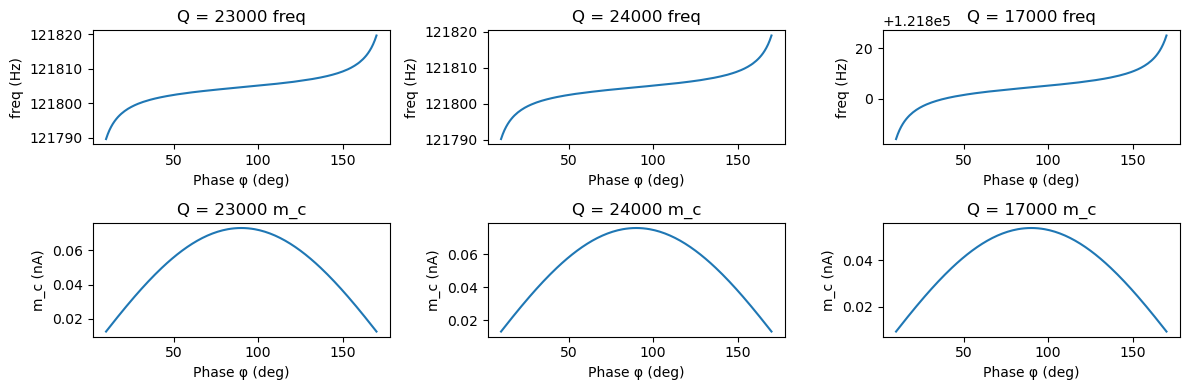

In [122]:
# 数据基本信息
print(f"Total samples: {X.shape[0]}")
print(f"Input X shape: {X.shape}, Target Y shape: {Y.shape}")
print(f"Each input sample: freq shape {X[0,:,0].shape}, m_c shape {X[0,:,1].shape}")

# freq 和 m_c 全数据全局数值范围
print(f"freq min: {np.nanmin(X[:,:,0]):.3f}, max: {np.nanmax(X[:,:,0]):.3f}")
print(f"m_c  min: {np.nanmin(X[:,:,1]):.3f}, max: {np.nanmax(X[:,:,1]):.3f}")
print(f"Q    min: {np.nanmin(Y):.3f}, max: {np.nanmax(Y):.3f}")

# 可视化：随机3个样本的 freq 和 m_c 曲线
import matplotlib.pyplot as plt

idxs = np.random.choice(X.shape[0], size=min(3, X.shape[0]), replace=False)
phi_deg = np.linspace(10, 170, X.shape[1])
plt.figure(figsize=(12,4))
for i, idx in enumerate(idxs):
    plt.subplot(2,3,i+1)
    plt.plot(phi_deg, X[idx,:,0])
    plt.title(f"Q = {Y[idx,0]:.0f} freq")
    plt.xlabel('Phase φ (deg)')
    plt.ylabel('freq (Hz)')
    plt.subplot(2,3,i+4)
    plt.plot(phi_deg, X[idx,:,1])
    plt.title(f"Q = {Y[idx,0]:.0f} m_c")
    plt.xlabel('Phase φ (deg)')
    plt.ylabel('m_c (nA)')
plt.tight_layout()
plt.show()



## 3. 网络结构定义

本节我们为微梁参数反演任务设计一个高效的神经网络模型。  
由于输入数据为多通道时序序列（每个样本为 180 个相位点的 [freq, m_c] 序列），适合采用一维卷积神经网络（1D-CNN）对整个时序进行特征提取。

### 网络结构简介

- **输入层**：每个样本输入为 shape = (180, 2)，即180个时序点、每点两个通道。
- **卷积编码器**：多层1D卷积（带ReLU激活）堆叠，逐步抽取时序特征。
- **全局池化**：自适应平均池化，将所有时序特征压缩为定长向量。
- **全连接头**：若干全连接（MLP）层，将抽取的特征映射为目标参数（本任务为Q）。


In [123]:
import torch
import torch.nn as nn

class MicrobeamPINNNet(nn.Module):
    def __init__(self, input_channels=2, output_dim=1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),   # [batch, 64, 1]
            nn.Flatten()               # [batch, 64]
        )
        self.head = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        # x: [batch, T, 2]  (需要转成 [batch, 2, T])
        x = x.permute(0,2,1)
        features = self.encoder(x)
        out = self.head(features)
        return out

# 网络实例化
net = MicrobeamPINNNet(input_channels=2, output_dim=1)
print(net)


MicrobeamPINNNet(
  (encoder): Sequential(
    (0): Conv1d(2, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU()
    (6): AdaptiveAvgPool1d(output_size=1)
    (7): Flatten(start_dim=1, end_dim=-1)
  )
  (head): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


## 4. PINN物理损失设计（含数据loss、初值、边界、PDE主方程残差）

### 4.1 数据监督损失（Data Loss）

用真实标签Q与神经网络预测输出的均方误差（MSE）作为主监督项：

$$
\mathcal{L}_{data} = \frac{1}{N} \sum_{i=1}^N (Q_{\text{pred}}^{(i)} - Q_{\text{true}}^{(i)})^2
$$

### 4.2 PDE主方程残差损失（PDE Residual Loss）

本部分利用微梁谐振系统的已知物理主方程，将神经网络反演得到的参数（如Q）与输入响应（freq, m_c）及系统常数共同带入动力学方程，对所有时序采样点计算残差并作为损失项。

#### 物理主方程

系统的动力学行为由如下两条非线性代数方程描述：

$$
\begin{cases}
- M \omega^2 y + (k_t - k_e) y + (k_{t3} - k_{e3}) \dfrac{3}{4} y^3 - F_{ac} \cos(\phi) = 0 \\
c \omega y - F_{ac} \sin(\phi) = 0
\end{cases}
$$

其中：
- $M$：等效质量
- $k_t, k_{t3}$：等效线性/三次刚度
- $k_e, k_{e3}$：电-机械耦合刚度
- $F_{ac}$：激励幅值，$F_{ac} = V_{ac} \cdot \text{trans\_factor}$
- $c$：阻尼系数，$c = \sqrt{M k_t} / Q$
- $\omega$：角频率（由观测freq换算：$\omega = 2\pi\,\text{freq}$）
- $y$：响应幅值（可由m_c等反推）
- $\phi$：激励相位

#### PDE残差定义

将网络预测参数（如Q）与输入时序样本带入上式，  
对每个采样点计算两个主方程的残差，分别记为$R_1$和$R_2$：

$$
\begin{align*}
R_1 &= - M \omega^2 y + (k_t - k_e) y + (k_{t3} - k_{e3}) \dfrac{3}{4} y^3 - F_{ac} \cos(\phi) \\
R_2 &= c \omega y - F_{ac} \sin(\phi)
\end{align*}
$$

PDE残差损失取为全时序残差的均方和：

$$
\mathcal{L}_{pde} = \frac{1}{N T} \sum_{i=1}^N \sum_{t=1}^T \left( R_1^{(i,t)}{}^2 + R_2^{(i,t)}{}^2 \right)
$$

- $N$为样本数，$T$为时序长度
- $R_1^{(i,t)}$、$R_2^{(i,t)}$为第$i$个样本第$t$个采样点的方程残差



In [124]:
import torch
import torch.nn as nn

# 4.1 数据监督损失（Data Loss）：MSE
def data_loss(pred, target):
    """
    计算监督损失（均方误差 MSE）
    参数:
        pred   : 网络输出 [batch, output_dim]
        target : 真实标签 [batch, output_dim]
    返回:
        标量 MSE 损失
    """
    return nn.functional.mse_loss(pred, target)



In [125]:
def pde_residual_loss(pred_Q, X_seq, constants, scaler, device='cpu'):
    """
    计算PINN物理主方程残差损失
    """
    # 1. 反归一化Q，并clip到物理可行区间
    Q = torch.from_numpy(scaler.inverse_transform(pred_Q.detach().cpu().numpy())).to(device).float()  # shape [batch, 1]
    Q = Q.squeeze(-1)  # [batch]
    Q = torch.clamp(Q, min=5000, max=49750)   # 强制Q在物理区间

    batch_size, T, _ = X_seq.shape

    # 2. 提取常数参数
    Mass      = torch.tensor(constants['Mass'],      device=device).float()
    k_t       = torch.tensor(constants['k_tt'],      device=device).float()
    k_t3      = torch.tensor(constants['k_t3'],      device=device).float()
    k_e       = torch.tensor(constants['k_e'],       device=device).float()
    k_e3      = torch.tensor(constants['k_e3'],      device=device).float()
    trans_factor = torch.tensor(constants['trans_factor'], device=device).float()
    Vac_ground  = torch.tensor(constants['Vac_ground'], device=device).float()
    phi_arr   = torch.tensor(constants['phi'],       device=device).float()  # shape [T]

    # 3. 输入的freq, m_c
    freq = X_seq[:,:,0]
    m_c  = X_seq[:,:,1]
    omega = 2 * torch.pi * freq

    # 4. 由m_c近似反推y
    y = m_c / (omega * trans_factor / 1e-9 + 1e-12)

    # 5. 其他参数
    F_ac = Vac_ground * trans_factor
    c = torch.sqrt(Mass * k_t) / (Q.view(-1,1) + 1e-6)   # 防止Q为0

    # 6. PDE残差
    R1 = (
        -Mass * omega**2 * y
        + (k_t - k_e) * y
        + (k_t3 - k_e3) * 0.75 * y**3
        - F_ac * torch.cos(phi_arr)
    )
    R2 = (
        c * omega * y
        - F_ac * torch.sin(phi_arr)
    )

    # 7. 残差缩放与clip（避免爆炸/inf）
    r1_std = R1.std().item() + 1e-8
    r2_std = R2.std().item() + 1e-8
    R1_scaled = R1 / r1_std
    R2_scaled = R2 / r2_std
    # 手动加权（比如α=0.7, β=0.3，也可尝试α=β=1）
    alpha, beta = 1.0, 1.0
    # 8. 求所有batch、时序的均方损失
    pde_loss = (alpha * R1_scaled**2 + beta * R2_scaled**2).mean()


    # 可选：debug输出极值
    #print("Q min/max", Q.min().item(), Q.max().item(), "R1_scaled min/max", R1_scaled.min().item(), R1_scaled.max().item())


    return pde_loss



In [126]:
def total_loss(
    pred,         # 网络输出Q [batch, 1]，归一化
    target,       # 标签Q [batch, 1]，归一化
    X_seq,        # 输入序列 [batch, T, 2]，原始物理量
    constants,    # 常数参数dict
    scaler,       # Q的StandardScaler
    device='cpu',
    lambda_data=1.0,
    lambda_pde=1.0
):
    """
    计算总loss：监督loss（MSE）+ PDE残差loss的加权和
    """
    loss_data = data_loss(pred, target)
    loss_pde  = pde_residual_loss(pred, X_seq, constants, scaler, device)
    loss = lambda_data * loss_data + lambda_pde * loss_pde
    #loss = lambda_data * loss_data 
    return loss, loss_data, loss_pde

### 4.x 初值/边界损失（Initial/Boundary Loss，保留待实现）

在物理信息神经网络（PINN）中，初值损失与边界损失通常用于强化模型在时序两端的物理约束，具体形式如下：

#### 初值损失（Initial Condition Loss）

通常写作：
$$
\mathcal{L}_{\text{init}} = \frac{1}{N} \sum_{i=1}^N \left( f_{\text{NN}}(\phi_0^{(i)}) - f_{\text{theory}}(\phi_0^{(i)}) \right)^2
$$
其中：
- $f_{\text{NN}}(\phi_0^{(i)})$ 为神经网络在序列起点 $\phi_0$ 的输出
- $f_{\text{theory}}(\phi_0^{(i)})$ 为理论/观测或物理边界的已知值

#### 边界损失（Boundary Condition Loss）

通常写作：
$$
\mathcal{L}_{\text{boundary}} = \frac{1}{N} \sum_{i=1}^N \left( f_{\text{NN}}(\phi_T^{(i)}) - f_{\text{theory}}(\phi_T^{(i)}) \right)^2
$$
其中：
- $\phi_T$ 为序列终点
- 其他符号同上

#### 在本参数反演任务中的当前情况

本任务中，神经网络的输出为全局参数 $Q$，输入为观测到的序列（freq, m_c）。  
由于网络直接预测的是参数 $Q$，而不是序列本身，因此只有在能由 $Q$ 及常数、输入等反推出起点/终点理论物理量的情况下，  
才能通过如下方式定义初/边值损失：

$$
\mathcal{L}_{\text{init/boundary}} = \frac{1}{N} \sum_{i=1}^N \left( f_{\text{theory}}(\phi_0^{(i)}, Q^{(i)}) - f_{\text{obs}}(\phi_0^{(i)}) \right)^2 + \left( f_{\text{theory}}(\phi_T^{(i)}, Q^{(i)}) - f_{\text{obs}}(\phi_T^{(i)}) \right)^2
$$

- $f_{\text{theory}}$ 表示由网络反演参数 $Q$、常数与输入推算得到的理论边界值
- $f_{\text{obs}}$ 为真实观测边界数据

**若后续获得解析解或理论边界表达式，可据此添加该loss项实现。当前本loss项暂未实现，仅作为结构预留。**


## 5. 训练主循环

每一轮(epoch)训练目标为最小化总损失：

$$
\mathcal{L}_{\text{total}} = \lambda_{\text{data}} \cdot \mathcal{L}_{\text{data}} + \lambda_{\text{pde}} \cdot \mathcal{L}_{\text{pde}}
$$

其中：

- $\mathcal{L}_{\text{data}} = \frac{1}{N} \sum_{i=1}^N (Q_{\text{pred}}^{(i)} - Q_{\text{true}}^{(i)})^2$
- $\mathcal{L}_{\text{pde}} = \frac{1}{N T} \sum_{i=1}^N \sum_{t=1}^T \left( R_1^{(i,t)}{}^2 + R_2^{(i,t)}{}^2 \right)$
- $R_1, R_2$ 为PDE主方程在每个采样点的残差
- $\lambda_{\text{data}}, \lambda_{\text{pde}}$ 为各损失项权重

**训练流程：**
- 对每个epoch，循环遍历batch，前向传播、计算loss、反向传播、参数更新
- 每轮在验证集上评估，记录训练与验证的各项loss
- 验证损失最优时保存模型，连续若干epoch无提升则提前停止（Early Stopping）


In [127]:
import os

# ==== 2.4 检查模型保存文件夹 ====
os.makedirs('model', exist_ok=True)
os.makedirs('results', exist_ok=True)

def train_pinn(
    net, tr_loader, te_loader, constants, st, device,
    epochs=1000, lr=1e-3, lambda_data=1.0, lambda_pde=1.0,
    patience=20, print_interval=50
):
    """
    PINN参数反演训练主循环
    """
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    best_val_loss = float('inf')
    patience_counter = 0

    history = {
        'train_loss': [],
        'train_data': [],
        'train_pde': [],
        'val_loss': [],
        'val_data': [],
        'val_pde': []
    }

    for epoch in range(epochs):
        net.train()
        train_loss = train_data = train_pde = 0.0
        n_train = 0

        for Xb, Yb in tr_loader:
            Xb = Xb.to(device)
            Yb = Yb.to(device)
            optimizer.zero_grad()
            pred = net(Xb)
            loss, loss_data, loss_pde = total_loss(
                pred, Yb, Xb, constants, st, device,
                lambda_data=lambda_data, lambda_pde=lambda_pde
            )
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * Xb.size(0)
            train_data += loss_data.item() * Xb.size(0)
            train_pde  += loss_pde.item()  * Xb.size(0)
            n_train += Xb.size(0)

        train_loss /= n_train
        train_data /= n_train
        train_pde  /= n_train

        net.eval()
        val_loss = val_data = val_pde = 0.0
        n_val = 0
        with torch.no_grad():
            for Xb, Yb in te_loader:
                Xb = Xb.to(device)
                Yb = Yb.to(device)
                pred = net(Xb)
                loss, loss_data, loss_pde = total_loss(
                    pred, Yb, Xb, constants, st, device,
                    lambda_data=lambda_data, lambda_pde=lambda_pde
                )
                val_loss += loss.item() * Xb.size(0)
                val_data += loss_data.item() * Xb.size(0)
                val_pde  += loss_pde.item()  * Xb.size(0)
                n_val += Xb.size(0)

        val_loss /= n_val
        val_data /= n_val
        val_pde  /= n_val

        history['train_loss'].append(train_loss)
        history['train_data'].append(train_data)
        history['train_pde'].append(train_pde)
        history['val_loss'].append(val_loss)
        history['val_data'].append(val_data)
        history['val_pde'].append(val_pde)

        # 打印进度
        if (epoch+1) % print_interval == 0 or epoch == 0:
            print(f"Epoch {epoch+1:4d} | Train Loss: {train_loss:.4e} (MSE {train_data:.4e}, PDE {train_pde:.4e}) | "
                  f"Val Loss: {val_loss:.4e} (MSE {val_data:.4e}, PDE {val_pde:.4e})")

        # 保存最优模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(net.state_dict(), 'model/pde_driven_45.pt')
            patience_counter = 0
        else:
            patience_counter += 1
            #if patience_counter > patience:
             #   print(f"Early stopping at epoch {epoch+1}. Best val loss: {best_val_loss:.4e}")
              #  break

    print("Training finished. Best validation loss:", best_val_loss)
    return history

# 用法示例
# history = train_pinn(net, tr_loader, te_loader, constants, st, device)


## 6. 训练模型（模型初始化与训练启动）

- 初始化网络结构（1D-CNN PINN）
- 加载归一化器、常数、DataLoader等
- 启动训练循环，保存最佳模型参数


In [128]:
# ==== 2.1 设备选择 ====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==== 2.2 定义网络结构 ====
# 假定你的1D-CNN模型类为 MicrobeamPINNNet
net = MicrobeamPINNNet(input_channels=2, output_dim=1).to(device)

# ==== 2.3 启动训练 ====
history = train_pinn(
    net, tr_loader, te_loader, constants, st, device,
    epochs=1000, lr=1e-3, lambda_data=1.0, lambda_pde=1.0,
    patience=20, print_interval=50
)


Epoch    1 | Train Loss: 2.0172e+00 (MSE 1.0037e+00, PDE 1.0134e+00) | Val Loss: 2.3873e+00 (MSE 1.3694e+00, PDE 1.0179e+00)
Epoch   50 | Train Loss: 1.0484e+00 (MSE 2.1743e-03, PDE 1.0463e+00) | Val Loss: 1.0251e+00 (MSE 1.2319e-03, PDE 1.0239e+00)
Epoch  100 | Train Loss: 1.0454e+00 (MSE 2.9659e-04, PDE 1.0451e+00) | Val Loss: 1.0238e+00 (MSE 2.7491e-04, PDE 1.0235e+00)
Epoch  150 | Train Loss: 1.0436e+00 (MSE 2.9804e-05, PDE 1.0436e+00) | Val Loss: 1.0241e+00 (MSE 3.1849e-05, PDE 1.0241e+00)
Epoch  200 | Train Loss: 1.0440e+00 (MSE 1.1871e-05, PDE 1.0440e+00) | Val Loss: 1.0241e+00 (MSE 1.3045e-05, PDE 1.0241e+00)
Epoch  250 | Train Loss: 1.0440e+00 (MSE 1.2487e-05, PDE 1.0440e+00) | Val Loss: 1.0244e+00 (MSE 4.9219e-05, PDE 1.0244e+00)
Epoch  300 | Train Loss: 1.0438e+00 (MSE 4.8014e-06, PDE 1.0438e+00) | Val Loss: 1.0242e+00 (MSE 5.8612e-06, PDE 1.0242e+00)
Epoch  350 | Train Loss: 1.0439e+00 (MSE 4.1013e-06, PDE 1.0439e+00) | Val Loss: 1.0242e+00 (MSE 9.2275e-06, PDE 1.0242e+00)


## 7. 训练Loss曲线与结果可视化

- 可视化训练与验证过程中各项loss（总loss、MSE loss、PDE loss）的变化趋势
- 方便分析模型收敛性、监督损失与物理约束损失的配比
- 训练历史loss曲线图片保存到 `results/` 文件夹，便于归档与后续分析


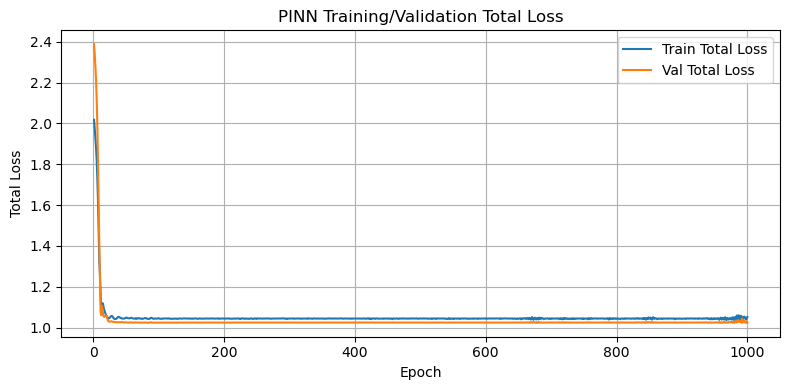

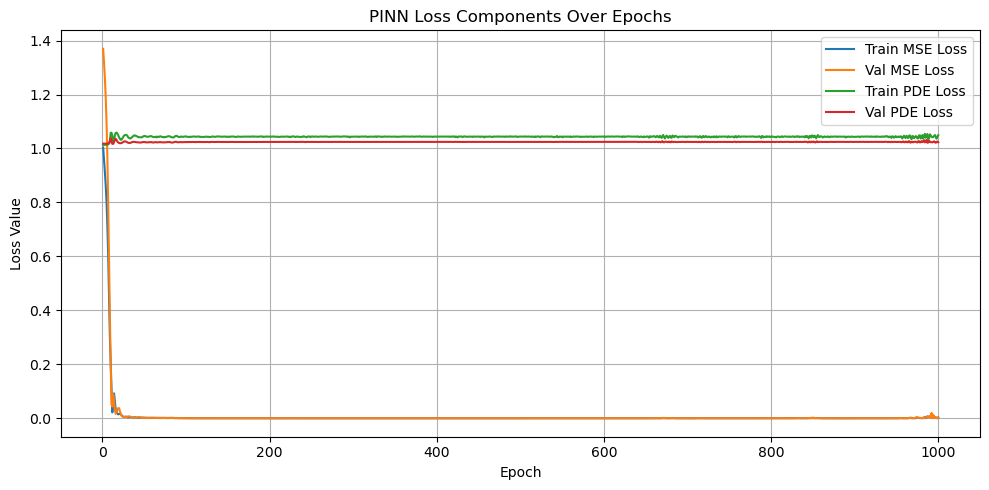

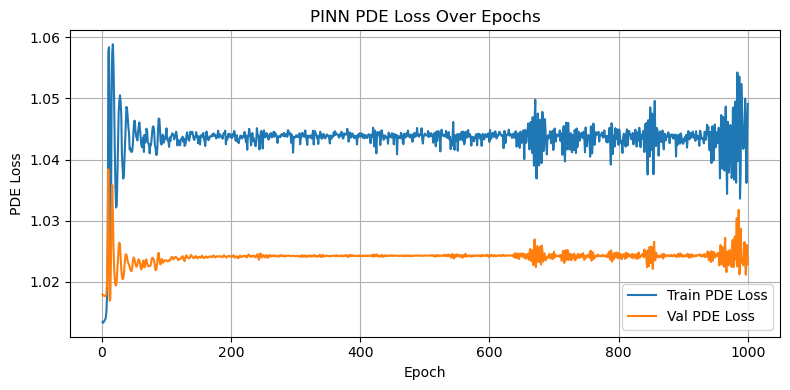

In [129]:
import matplotlib.pyplot as plt

epochs = len(history['train_loss'])

# 1. 总loss曲线
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs+1), history['train_loss'], label='Train Total Loss')
plt.plot(range(1, epochs+1), history['val_loss'], label='Val Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('PINN Training/Validation Total Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('results/loss_curve_total_pde_driven_45.png', dpi=150)
plt.show()   # 显示在notebook

# 2. MSE、PDE子项loss曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), history['train_data'], label='Train MSE Loss')
plt.plot(range(1, epochs+1), history['val_data'], label='Val MSE Loss')
plt.plot(range(1, epochs+1), history['train_pde'], label='Train PDE Loss')
plt.plot(range(1, epochs+1), history['val_pde'], label='Val PDE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('PINN Loss Components Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('results/loss_curve_components_pde_driven_45.png', dpi=150)
plt.show()   # 显示在notebook

# 2.PDE子项loss曲线
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs+1), history['train_pde'], label='Train PDE Loss')
plt.plot(range(1, epochs+1), history['val_pde'], label='Val PDE Loss')
plt.xlabel('Epoch')
plt.ylabel('PDE Loss')
plt.title('PINN PDE Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('results/loss_curve_pde_pde_driven_45.png', dpi=150)
plt.show()   # 显示在notebook


## 8. 模型保存与可视化结果导出

- 训练过程中最优模型自动保存至 `model/best_pinn_model.pt`
- 评估和所有可视化图片保存在 `results/` 文件夹，便于归档与后续分析


/var/folders/n7/v600f1k91rjfkqj_812w6ts40000gn/T/ipykernel_42300/2951798656.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('model/pde_dri

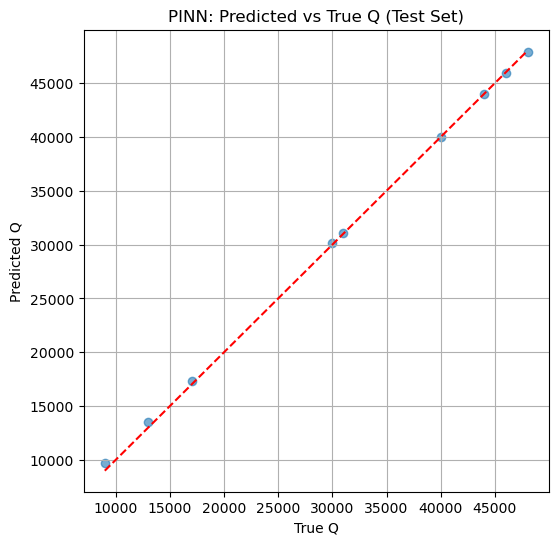

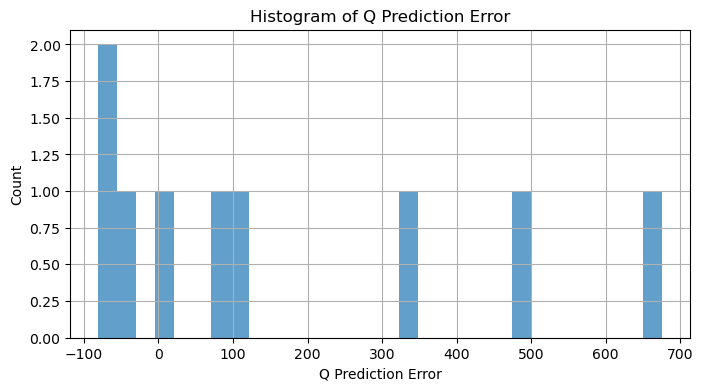

真实Q vs 预测Q（按绝对误差降序）前20条：


,True_Q,Pred_Q,Error,AbsError
6,9000.0,9675.578125,675.578125,675.578125
8,13000.0,13480.074219,480.074219,480.074219
7,17000.0,17345.322266,345.322266,345.322266
1,30000.0,30110.421875,110.421875,110.421875
2,31000.0,31086.314453,86.314453,86.314453
3,48000.0,47919.480469,-80.519531,80.519531
5,46000.0,45943.339844,-56.660156,56.660156
0,44000.0,43967.187500,-32.812500,32.812500
4,40000.0,40015.234375,15.234375,15.234375


In [130]:
# 1. 加载最佳模型参数
net.load_state_dict(torch.load('model/pde_driven_45.pt', map_location=device))
net.eval()

# ... 预测、计算误差等同前 ...

X_true = torch.from_numpy(Xte).to(device)
Y_true = torch.from_numpy(Yte).to(device)

with torch.no_grad():
    Q_pred_norm = net(X_true).cpu().numpy()
    Q_pred = st.inverse_transform(Q_pred_norm)
    Q_true = st.inverse_transform(Yte)
q_error = Q_pred.flatten() - Q_true.flatten()
# 2. 可视化保存
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(Q_true, Q_pred, alpha=0.6)
plt.plot([Q_true.min(), Q_true.max()], [Q_true.min(), Q_true.max()], 'r--')
plt.xlabel('True Q')
plt.ylabel('Predicted Q')
plt.title('PINN: Predicted vs True Q (Test Set)')
plt.grid(True)
plt.savefig('results/q_pred_vs_true_pde_driven_45.png', dpi=150)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(q_error, bins=30, alpha=0.7)
plt.xlabel('Q Prediction Error')
plt.ylabel('Count')
plt.title('Histogram of Q Prediction Error')
plt.grid(True)
plt.savefig('results/q_error_hist_pde_driven_45.png', dpi=150)
plt.show()

# 只展示前20条对照结果（可自定义n条）
n_display = 20
df_compare = pd.DataFrame({
    'True_Q': Q_true.flatten(),
    'Pred_Q': Q_pred.flatten(),
    'Error': (Q_pred - Q_true).flatten()
})

# 按误差绝对值降序排列，方便发现大误差
df_compare['AbsError'] = df_compare['Error'].abs()
df_compare_sorted = df_compare.sort_values(by='AbsError', ascending=False)

print("真实Q vs 预测Q（按绝对误差降序）前{}条：".format(n_display))
display(df_compare_sorted.head(n_display))

# 若要保存csv也很方便
df_compare_sorted.to_csv('results/q_true_pred_compare_pde_driven_45.csv', index=False)


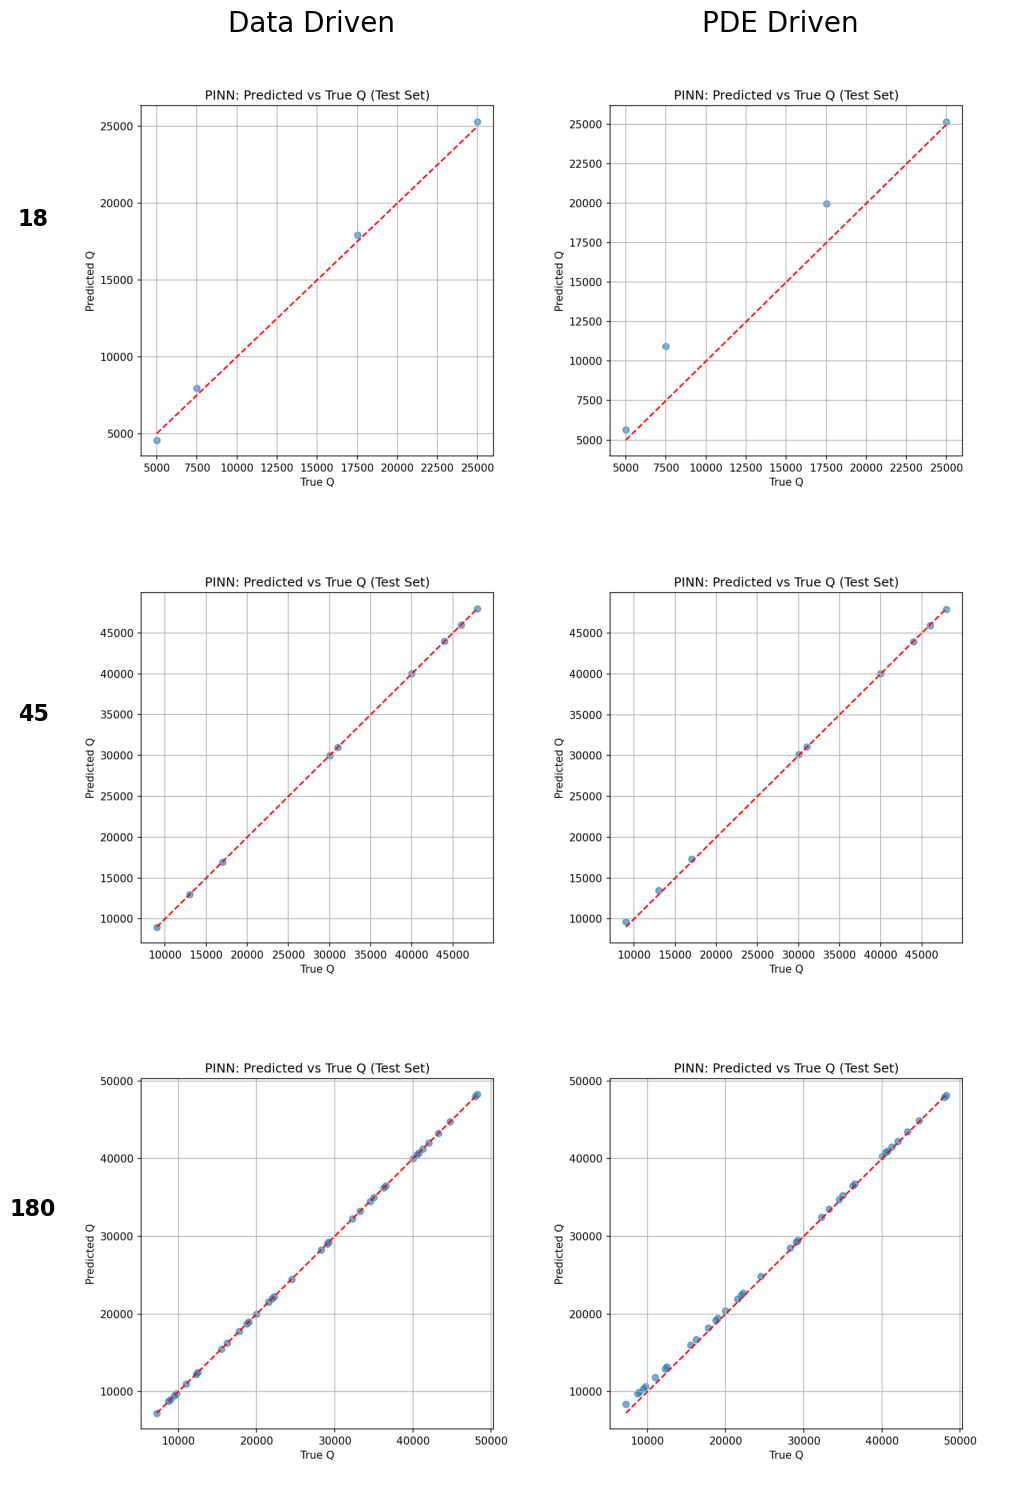

按比例拼接完成，保存于：integrated_picture/q_pred_vs_true_comparison.png


In [141]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 图片文件路径（按顺序：data-driven, pde-driven，各三张，顺序为18、45、180）
img_paths = [
    'results/q_pred_vs_true_data_driven_18.png',
    'results/q_pred_vs_true_pde_driven_18.png',
    'results/q_pred_vs_true_data_driven_45.png',
    'results/q_pred_vs_true_pde_driven_45.png',
    'results/q_pred_vs_true_data_driven_180.png',
    'results/q_pred_vs_true_pde_driven_180.png',
]

# 行、列标签
row_labels = ['18', '45', '180']
col_labels = ['Data Driven', 'PDE Driven']

# 创建保存目录
os.makedirs('integrated_picture', exist_ok=True)

# 每个图宽:高 = 2:1，3行2列，整体宽:高 = 4:3，所以设置为12x9更合适
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

for i in range(3):
    for j in range(2):
        img = mpimg.imread(img_paths[i*2 + j])
        axes[i, j].imshow(img)
        axes[i, j].axis('off')

for j, col in enumerate(col_labels):
    axes[0, j].set_title(col, fontsize=20, pad=15)

for i, row in enumerate(row_labels):
    ypos = [0.85, 0.52, 0.19][i]
    fig.text(0.01, ypos, row, va='center', ha='center', fontsize=16, fontweight='bold', rotation=0)

plt.tight_layout(rect=[0.045, 0, 1, 1])
plt.subplots_adjust(wspace=0.03, hspace=0.07)

save_path = 'integrated_picture/q_pred_vs_true_comparison.png'
plt.savefig(save_path, dpi=300)
plt.show()
print(f"按比例拼接完成，保存于：{save_path}")
